# DC-EGM med Max's Model

## load packages and dependencies

In [1]:
#Dependencies
import jax.numpy as jnp
import numpy as np
from dcegm.pre_processing.setup_model import setup_model
import jax

from typing import Tuple

import pandas as pd
import matplotlib.pyplot as plt

from dcegm.sim_interface import get_sol_and_sim_func_for_model
from dcegm.simulation.sim_utils import create_simulation_df

from scipy.optimize import minimize

import dfols
import statsmodels.api as sm

import os

from dcegm.interface import validate_exogenous_processes

# ── Configurating file-location -────────────────────────────────────────────────
DATA_DIR    = "/Users/frederiklarsen/Data"
FILE_UDD1   = os.path.join(DATA_DIR, "momenter/moments_udd1.txt")
FILE_UDD2   = os.path.join(DATA_DIR, "momenter/moments_udd2.txt")
FILE_UDD3   = os.path.join(DATA_DIR, "momenter/moments_udd3.txt")
Mortality   = os.path.join(DATA_DIR, "mortality.xlsx")
# ────────────────────────────────────────────────────────────────────────────────

##### Git Commit Hash ee6660e #####
##### Git Branch = origin(aux-budget) #####
# ────────────────────────────────────────────────────────────────────────────────


jax.config.update("jax_enable_x64", True)

## Load Data 

In [162]:
# Read CSV
df_edu_1 = pd.read_csv(FILE_UDD1)
df_edu_2 = pd.read_csv(FILE_UDD2)
df_edu_3 = pd.read_csv(FILE_UDD3)
# read mortality and discard seoncd and third column
df_mort = pd.read_excel(Mortality, sheet_name="DOD", usecols=[0, 3])

# 2) standardize colomn name and remove _FREQ_ column
for df in (df_edu_1, df_edu_2, df_edu_3):
    # Rename ALDER → age
    if "ALDER" in df.columns:
        df.rename(columns={"ALDER": "age"}, inplace=True)
    # Remove _FREQ_-column if it exists
    if "_FREQ_" in df.columns:
        df.drop(columns=["_FREQ_"], inplace=True)


 # 3) Divide wage by 10 to get it in 100000 dkk
for df in (df_edu_1, df_edu_2, df_edu_3):
    if "avg_wage" in df.columns:
        df["avg_wage"] = df["avg_wage"]

# 4) (Valgfrit) Kontrolprint 
#df_edu_1

# Estimate parameters that are not structurally estimated

## Wage parameters

### Education level 1 - low education

Estimated betas: β0=-6.8961, β1=0.0272, β2=-0.0002


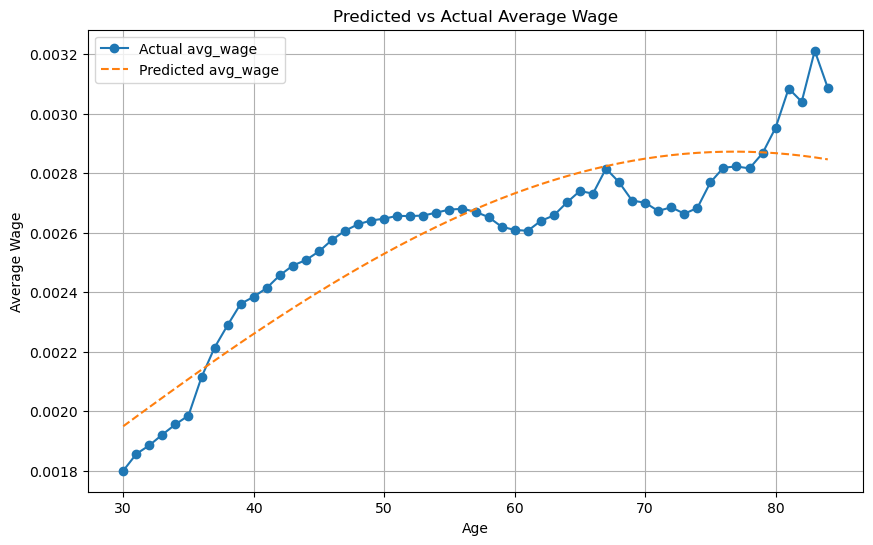

In [247]:
# 1) Take your empirical avg_wage per age (in model units) and turn back to real-kr:
df = df_edu_1.copy()


# 2) Build the regression dataset
df['log_wage'] = np.log(df['avg_wage'])
X = sm.add_constant(np.column_stack((df['age'], df['age']**2)))   # [1, age, age²] 

# 3) Run OLS: log(wage) = β0 + β1·age + β2·age² + error
model = sm.OLS(df['log_wage'], X, missing='drop').fit()

# 4) Extract your β’s
beta0, beta1, beta2 = model.params
print(f"Estimated betas: β0={beta0:.4f}, β1={beta1:.4f}, β2={beta2:.4f}")

df["predicted"]=np.exp(beta0 + beta1*df["age"] + beta2*df["age"]**2)


#plot predicted vs actual
plt.figure(figsize=(10, 6))
plt.plot(df["age"], df["avg_wage"], label="Actual avg_wage", marker='o')
plt.plot(df["age"], df["predicted"], label="Predicted avg_wage", linestyle='--')
plt.xlabel("Age")
plt.ylabel("Average Wage")
plt.title("Predicted vs Actual Average Wage")
plt.legend()
plt.grid()
plt.show()

### Education level 2 - medium education

In [ ]:
# 1) Take your empirical avg_wage per age (in model units) and turn back to real-kr:
df = df_edu_2.copy()

# 2) Build the regression dataset
df['log_wage'] = np.log(df['avg_wage'])
X = sm.add_constant(np.column_stack((df['age'], df['age']**2)))  # [1, age, age²] 

# 3) Run OLS: log(wage) = β0 + β1·age + β2·age² + error
model = sm.OLS(df['log_wage'], X, missing='drop').fit()

# 4) Extract your β’s
beta0, beta1, beta2 = model.params
print(f"Estimated betas: β0={beta0:.4f}, β1={beta1:.4f}, β2={beta2:.4f}")

df["predicted"]=np.exp(beta0 + beta1*df["age"] + beta2*df["age"]**2)

#plot predicted vs actual
# plt.figure(figsize=(10, 6))
# plt.plot(df["age"], df["avg_wage"], label="Actual avg_wage", marker='o')
# plt.plot(df["age"], df["predicted"], label="Predicted avg_wage", linestyle='--')
# plt.xlabel("Age")
# plt.ylabel("Average Wage")
# plt.title("Predicted vs Actual Average Wage")
# plt.legend()
# plt.grid()
# plt.show()

### Education level 3 - high education

In [ ]:
# 1) Take your empirical avg_wage per age (in model units) and turn back to real-kr:
df = df_edu_3.copy()

# 2) Build the regression dataset
df['log_wage'] = np.log(df['avg_wage'])
X = sm.add_constant(np.column_stack((df['age'], df['age']**2)))  # [1, age, age²] 

# 3) Run OLS: log(wage) = β0 + β1·age + β2·age² + error
model = sm.OLS(df['log_wage'], X, missing='drop').fit()

# 4) Extract your β’s
beta0, beta1, beta2 = model.params
print(f"Estimated betas: β0={beta0:.4f}, β1={beta1:.4f}, β2={beta2:.4f}")

df["predicted"]=np.exp(beta0 + beta1*df["age"] + beta2*df["age"]**2)

#plot predicted vs actual
# plt.figure(figsize=(10, 6))
# plt.plot(df["age"], df["avg_wage"], label="Actual avg_wage", marker='o')
# plt.plot(df["age"], df["predicted"], label="Predicted avg_wage", linestyle='--')
# plt.xlabel("Age")
# plt.ylabel("Average Wage")
# plt.title("Predicted vs Actual Average Wage")
# plt.legend()
# plt.grid()
# plt.show()

### Estimate mortality

In [41]:
df = pd.read_excel(Mortality, sheet_name="DOD")
ages  = df["age"].values     # e.g. 35,36,…,85
q_obs = df["mortality"].values  # observed probability of dying at each age

# --- 2) define the model hazard
def hazard(ages, alpha1, alpha2, a0=30):
    return alpha1 * (np.exp(alpha2 * (ages - a0)) - 1)

# --- 3) negative log‐likelihood
def neg_loglik(theta, ages, q_obs, a0=30):
    alpha1, alpha2 = theta
    p = hazard(ages, alpha1, alpha2, a0=a0)
    p = np.clip(p, 1e-8, 1-1e-8)
    ll = q_obs * np.log(p) + (1 - q_obs) * np.log(1 - p)
    return -np.sum(ll)

# --- 4) MLE
init = np.array([0.0005, 0.1])
bnds = [(1e-10, 1.0), (1e-5, 1.0)]
res = minimize(
    neg_loglik,
    init,
    args=(ages, q_obs),
    method="L-BFGS-B",
    bounds=bnds,
    options={"disp": True}
)

alpha1_hat, alpha2_hat = res.x
print(f"MLE estimates: alpha1 = {alpha1_hat:.6f}, alpha2 = {alpha2_hat:.6f}")

#plot predicted vs actual
# plt.figure(figsize=(5, 3))
# plt.plot(ages, q_obs, label="Observed Mortality", marker='o')
# plt.plot(ages, hazard(ages, alpha1_hat, alpha2_hat), label="Predicted Mortality", linestyle='--')
# plt.xlabel("Age")
# plt.ylabel("Mortality Rate")
# plt.title("Predicted vs Actual Mortality Rate")
# plt.legend()
# plt.grid()
# plt.show()

MLE estimates: alpha1 = 0.000417, alpha2 = 0.099277


In [7]:
# # # survival function
# def prob_survival(period, options, survival):
    
#     death_prob = options["alpha1"] * (np.exp(options["alpha2"] * period) - 1)

#     prob_vector_alive = jnp.array([death_prob, 1-death_prob])
    
#     prob_vector_dead = jnp.array([1,0])

#     prob_vector = jnp.where(survival == 1, prob_vector_alive, prob_vector_dead)

#     return prob_vector

In [6]:
# ## Improved version using JAX

# def prob_survival(period, options, survival):
#     alpha1 = options["alpha1"]
#     alpha2 = options["alpha2"]
#     # use jnp.exp, not np.exp
#     death_prob = alpha1 * (jnp.exp(alpha2 * period) - 1.0)

#     # build the 2-state transition vector: if you’re alive (survival==1) you die
#     # with probability death_prob, or stay alive with 1−death_prob
#     prob_alive = jnp.stack([1.0 - death_prob, death_prob], axis=-1)
#     # if you’re already dead, you stay dead
#     prob_dead  = jnp.array([0.0, 1.0])

#     # survival may be a scalar or array; do the broadcast correctly:
#     #   if survival is shape (n,), this produces (n,2)
#     return jnp.where(survival[..., None] == 1, prob_alive, prob_dead)

In [42]:
def prob_survival(period, options, survival):
    alpha1 = options["alpha1"]
    alpha2 = options["alpha2"]

    # death probability must be jnp.exp, and clipped to [0,1]
    death_prob = alpha1 * (jnp.exp(alpha2 * period) - 1.0)
    death_prob = jnp.clip(death_prob, 0.0, 1.0)     # just in case it ever goes outside

    # alive: P(dead next) = death_prob,  P(alive next) = 1 - death_prob
    probs_alive = jnp.stack([death_prob, 1.0 - death_prob], axis=-1)   # shape (n_agents, 2)

    # dead:   P(dead next) = 1,           P(alive next) = 0
    probs_dead = jnp.broadcast_to(jnp.array([1.0, 0.0]), probs_alive.shape)

    # select rowwise based on current survival
    # survival is shape (n_agents,), so survival[...,None] is (n_agents,1)
    return jnp.where(survival[..., None] == 1, probs_alive, probs_dead)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 6.860e+04
Date:                Fri, 09 May 2025   Prob (F-statistic):               0.00
Time:                        15:47:15   Log-Likelihood:                 1084.5
No. Observations:                 500   AIC:                            -2161.
Df Residuals:                     496   BIC:                            -2144.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7234      0.006    284.662      0.0

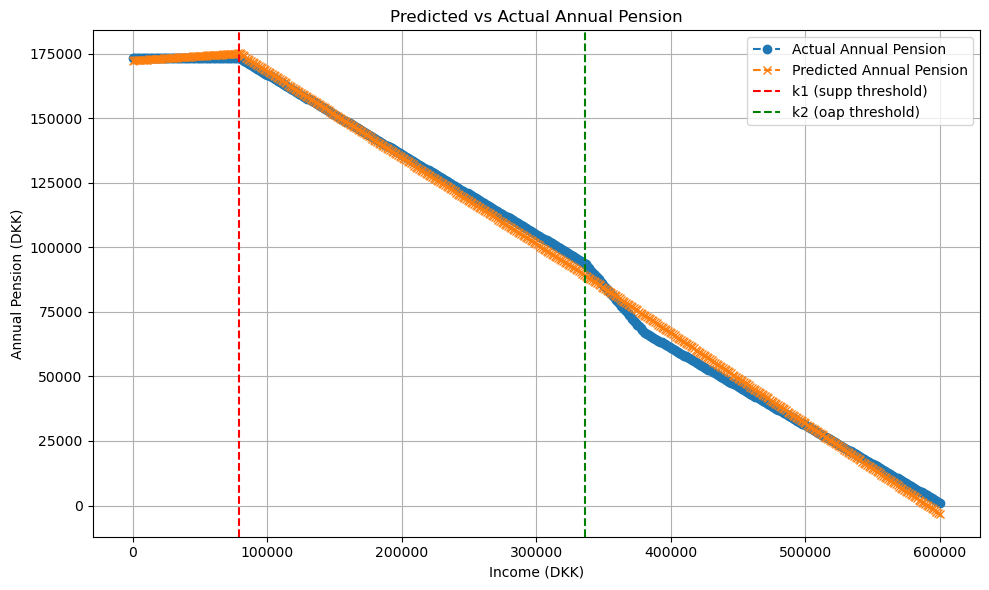

In [43]:
# estimate old age pension as function of income
k1 = options["model_params"]["supp_threshold"]        # e.g. 0.793 → 79 300 kr
k2 = options["model_params"]["oap_threshold"]         # e.g. 3.3592 → 335 920 kr
max_supp = options["model_params"]["oap_max_supplement"]
supp_rate = options["model_params"]["supp_reduction_rate"]
base_oap  = options["model_params"]["oap_base_amount"]
oap_rate  = options["model_params"]["oap_reduction_rate"]

# 2) Build a grid of (relative) incomes from 0 to 6 (=600 000 kr)
inc = np.linspace(0, 6, 500)  

# 3) Compute the schedule exactly as you did before
inc_over_supp = np.maximum(0, inc - k1)
supplement    = np.maximum(0, max_supp - supp_rate * inc_over_supp)

inc_over_oap  = np.maximum(0, inc - k2)
oap           = np.maximum(0, base_oap - oap_rate * inc_over_oap)

annual_pension = supplement + oap  # in “per 100 000 kr” units

# 4) Create the linear‐spline basis (two kinks at k1 and k2)
L1 = np.maximum(0, inc - k1)
L2 = np.maximum(0, inc - k2)

# 5) Stack into a design matrix [1, inc, (inc−k1)+, (inc−k2)+]
X = np.column_stack([inc, L1, L2])
X = sm.add_constant(X)  # adds an intercept β₀

# 6) Run the regression
spline_model = sm.OLS(annual_pension, X).fit()

print(spline_model.summary())


# assume inc is in “100 000 kr” units (0–6), and annual_pension in relative units (0–1.75)
inc_dkk = inc * 100_000
annual_pension_dkk    = annual_pension * 100_000
predicted_pension_dkk = spline_model.predict(X) * 100_000

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(inc_dkk, annual_pension_dkk,    linestyle='--', marker='o', label="Actual Annual Pension")
ax.plot(inc_dkk, predicted_pension_dkk, linestyle='--', marker='x', label="Predicted Annual Pension")

ax.axvline(x=k1*100_000, color='r', linestyle='--', label="k1 (supp threshold)")
ax.axvline(x=k2*100_000, color='g', linestyle='--', label="k2 (oap threshold)")

ax.set_xlabel("Income (DKK)")
ax.set_ylabel("Annual Pension (DKK)")
ax.set_title("Predicted vs Actual Annual Pension")

# format both axes with comma‐thousands

ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# ====================================================================================================================

# Structural Estimation

## Initiatal parameters - some are estimated above, the rest to be structuraly estimated

In [384]:
params_initial = {}
params_initial["interest_rate"] = 0.01
params_initial["sigma"] = 0.15787157 # income shock scale
params_initial["lambda"] = 0.91806921 # taste shock scale

# discount factor
params_initial["beta"] = 0.99468334

# parameters for the utility function
params_initial["rho"]=0.76492381

# disutility of each hours choice
params_initial["gamma"]=jnp.array([0.82942285,1.554308,1.97723635,1.49246861]) 


# wage parameters
# ----- EDU LEVEL 1 -----
params_initial["beta0"]=-6.8961
params_initial["beta1"]=0.0272
params_initial["beta2"]=-0.0002

# ----- EDU LEVEL 2 -----
# params_initial["beta0"]=-6.20514
# params_initial["beta1"]= 0.02899
# params_initial["beta2"]=-0.00040533

# ----- EDU LEVEL 3 -----
# params_initial["beta0"]=-5.95253
# params_initial["beta1"]= 0.02917
# params_initial["beta2"]=-0.00043455

# Age component disutility
# params_initial["kappa1"]=0.06931974
params_initial["kappa2"]=0.00315697

# transsition cost
params_initial["phi"]=0.96152787

# mortality parameters
params_initial["alpha1"]=0.000417
params_initial["alpha2"]=0.099277

# bequest parameters
params_initial["b_scale"]=1.28373597
params_initial["xi"]=0.26186999


# labor market parameters
params_initial["eta_edu1"]=2.03773807


params=params_initial.copy()

## Options for model - Choices and states

In [385]:
n_periods = 55
choices = np.arange(5) # 5 choices

options = {
    "model_params": {
        #"quadrature_points_stochastic": 5, 
        "n_quad_points_stochastic": 25,
        "n_periods": n_periods,
        "choices": choices, # 4 choices
        "hours": jnp.array([0,250,750,1200,1700]), #list 
        "max_hours": 1500,
        "start_age": 30,
        "inc_threshold": 6.0,
        "tax_base_rate": 0.37,
        "tax_top_rate": 0.5,
        "retirement_age": 67,
        "oap_base_amount":0.80328,
        "oap_max_supplement": 0.92940,
        "supp_threshold": 0.79300,
        "oap_threshold": 3.3592,
        "supp_reduction_rate": 0.309,
        "oap_reduction_rate": 0.3,
        "alpha1": 0.000417, # independently estimated parameter for survival probability
        "alpha2": 0.1,  # independently estimated parameter for survival probability
        "max_init_experience": 5,
        "max_ret_period": 45, # Age 75
        "min_ret_period": 30, # Age 60
    },
    "state_space": {
        "n_periods": n_periods,
        "choices": choices, # 4 choices
        "continuous_states": {
            "wealth": np.linspace(0, 50, 20),
            "experience": jnp.linspace(0, 1, 5).astype(float) # 1 experince grid point, if experience can only go up by a year - more points if it is a fraction based on hours worked
        },
        "exogenous_processes": {
            "survival": {
                "transition": prob_survival,
                "states": [0, 1],
            },
        },
    },
}

## Defining utility

In [386]:
def flow_util(consumption, choice, params, period, options, lagged_choice, survival):
    # Utility parameter
    rho = params["rho"]

    #Disutility parameters
    age = (options["start_age"] + period).astype(float)
    gamma = params["gamma"][choice-1] #remove the first element


    ##############################################
    ########## Disutility of working #############
    ##############################################
    working = (choice > 0) # 1 if choice is working, 0 if not
    # -------  Zero disutility from working if unemployed

    # Age component of disutility
    # age_linear   = jnp.where((age < 40),
    #                         params["kappa1"] * (40-age)/,
    #                         0.0)
    age_quadratic = jnp.where(age > 55,
                            params["kappa2"] * (age-55)**2,
                            0.0)
    
    #+ age_linear 

    # estimate total disutility
    disutil_0 = working * (1.0 + age_quadratic) * gamma

    # No disutility from working, if you dont work. 
    disutil = jnp.where(working, disutil_0, 0.0) # if working == 0, disutility = 0
    
    ##############################################
    ############# Transaction costs  #############
    ##############################################

    # transition cost when going from working to unemployed, and vice versa
    trans_cost = jnp.where(choice != lagged_choice , params["phi"], 0.0)# from changing choice  


    #Utility for agents that are alive. 
    u = ((consumption ** (1 - rho)) - 1) / (1 - rho) - disutil - trans_cost #working*gamma*hours*(1+(kappa1*age)*age_1+(kappa2*age_2)**2*age_2) #jax.lax.select(working, gamma, 0) - if a NaN included

    #Utility for agents that are dead. no utility from consumption, only utility from bequest. 
    #u_dead = jnp.where(first_time_dead, bequest, 0.0) # if first time dead, utility is -inf

    #u = jnp.where(survival == 1, u_alive, u_dead) # if survival == 1, utility is alive utility, else dead utility

    return u

def marginal_utility(consumption, params):
    rho = params["rho"]
    u_prime = consumption ** (-rho)
    return u_prime


def inverse_marginal_utility(marginal_utility, params):
    rho = params["rho"]
    return marginal_utility ** (-1 / rho)


utility_functions = {
    "utility": flow_util,
    "inverse_marginal_utility": inverse_marginal_utility,
    "marginal_utility": marginal_utility,
}


In [341]:
#test zero consumption, zero choice, zero lagged choice, survival 1

flow_util(0, 0, params, jnp.array(0), options["model_params"], 0, 1)

Array(-1.32471012, dtype=float64)

## Budget constraint

In [387]:
def budget_dcegm(
    lagged_choice,
    savings_end_of_previous_period,
    income_shock_previous_period,
    params,
    options,
    period,
    survival,
    experience,
):
    # Interest on savings
    interest_factor = 1 + params["interest_rate"]
    # Age
    age = (options["start_age"] + period).astype(float) # as float to avoid int64, which complicates wage function.
    # Working hours. indexed on lagged choice, since income today is last period's choice
    hours = options["hours"][lagged_choice]

    # Survival
    alive = (survival == 1)
    death = 1 - alive  # death probability

    # if survival == 0, then choice = 0

    # ====================================================================
    # ————---------------------- Experience ------------------------------
    # ====================================================================    

    # Count total experience as current periods experience times period
    initial_experience = options["max_init_experience"] = 5
    acc_exp = initial_experience + (period * experience)




    # ====================================================================
    # ————------------------------- Wage —————----------------------------
    # ====================================================================

    
    # Wage function, with wage parameters estimated above.
    wage_0 = jnp.exp(params["beta0"] +
        params["beta1"] * age
        + params["beta2"] * age**2
        + income_shock_previous_period
    )
    labor_income = wage_0 * hours

    # ====================================================================
    # ————--------------------- Tax-function —————------------------------
    # ====================================================================

    # Simpple tax-function)
    tax_rate = jnp.where(
        labor_income <= options["inc_threshold"],
        options["tax_base_rate"],
        options["tax_top_rate"],
    )
    net_labor = labor_income * (1 - tax_rate)



    # ====================================================================
    # ————------------------- Old Age Pension —————-----------------------
    # ====================================================================

    # 1) grab your knots
    k1 = options["supp_threshold"]
    k2 = options["oap_threshold"]

    # 2) extract the four coefficients from your fitted statsmodels OLS
    b0, b1, b2, b3 = spline_model.params    # [(Intercept), inc, (inc-k1)+, (inc-k2)+]

    # 3) define a vectorized “predict pension” function
    def predict_oap(labor_income):
        L1 = jnp.maximum(0, labor_income - k1)
        L2 = jnp.maximum(0, labor_income - k2)
        return b0 + b1*labor_income + b2*L1 + b3*L2

    oap_estimate = predict_oap(labor_income)*0.6*(age >= options["retirement_age"]) # 0.4 is the tax rate


    # 1) Determine if agent is retired
    retirement_age = jnp.where(age >= options["retirement_age"], 1, 0)

    # 2) Calculated income above supplement threshold
    income_over_supp = jnp.maximum(0.0, labor_income - options["supp_threshold"])

    # 3)Reduction in supplement
    supp_reduction = options["supp_reduction_rate"] * income_over_supp
    supplement = jnp.maximum(0.0, options["oap_max_supplement"] - supp_reduction)

    # calculate old age pension - full oap until income reaches threshold and then oap is reduced with with oap_reduction_rate pr unit of income above threshold
    income_over_oap = jnp.maximum(0.0, labor_income - options["oap_threshold"])
    oap_reduction = options["oap_reduction_rate"] * income_over_oap
    
    oap = jnp.maximum(0.0, options["oap_base_amount"] - oap_reduction)

    # 4) Samlet årlig pension (grundbeløb + supplement)
    period_pension = oap_estimate

    # 5) Skaler til måned (eller periode­længde) — her antager vi måned
    # period_pension = jnp.where(
    #     retirement_age,
    #     annual_pension,
    #     0.0
    # )

    # Period_pension after tax
    # period_pension = period_pension * (1 - tax_rate)

    # ====================================================================
    # ————---------------- Labor Market Pensions ——-----------------------
    # ====================================================================


    # 1) Calculate labor market pension
    lmpens = params["eta_edu1"] * experience
    # 2) Calculate labor market pension after tax
    lmpens = lmpens * (1 - 0.4)
    lumpsum = jnp.where((age == 67), lmpens, 0.0)



    # ====================================================================
    # ————---------------------- Resources -—————-------------------------
    # ====================================================================


    # Total resource available for consumption
    resource = (
        interest_factor * savings_end_of_previous_period
        + net_labor
        + period_pension
        + lumpsum
    )

    #resource = jnp.where(alive, resource_raw, 0.0) # if alive, resource is resource_raw, else 0.0

    # resource = jnp.where(
    # alive,
    # jnp.maximum(resource_raw, 0.5),
    # 0.0,
    # )

    aux_dict = {
        "wage": wage_0,
        "net_labor": net_labor,
        "period_pension": period_pension,
        "lumpsum": lumpsum,
        "experience": experience,
        "acc_exp": acc_exp,
    }

    # max(resource, 0.5) to avoid negative consumption - 0 if agent is dead.
    return jnp.maximum(resource,0.5), aux_dict

## Final period util - for solving model

In [388]:
def final_period_utility(wealth: float, params,) -> Tuple[float, float]:
    b_scale = params["b_scale"]
    xi = params["xi"]
    
    bequest = b_scale * ((wealth ** (1 - xi)) - 1) / (1 - xi)

    return bequest

# #define final_period_utility as bequest
# def final_period_utility(wealth, choice, params, period, options, lagged_choice, survival):
#     # bequest function
#     xi = params["xi"]
#     b_scale = params["b_scale"]
#     bequest = b_scale * ((wealth ** (1 - xi)) - 1) / (1 - xi)
#     return bequest


def marginal_final(wealth: float, params):
    xi = params["xi"]
    return wealth ** (-xi)


final_period_utility = {
    "utility": final_period_utility,
    "marginal_utility": marginal_final,
}

## Solve the model

### Create state space

In [389]:
# Create state space


def next_period_experience(period, lagged_choice, experience, options):
    # make sure we're working in float32
    experience = experience.astype(float)
    period     = period.astype(float)

    # grab hours and max_hours as float32
    hours      = options["hours"][lagged_choice]
    max_hours  = jnp.array(options["max_hours"])
    init_exp   = jnp.array(options["max_init_experience"])
    worked = (hours > 0)

    # t+init_experience
    max_experience_period = period + init_exp

    # E_{t+1} = ((t * E_t) + h_t / max_hours) / (t+1)
    next_exp = (
        (max_experience_period - 1.0) * experience
        + (hours/max_hours)
    ) / max_experience_period

    return next_exp  # still float32

# def next_period_experience_fraction(period, lagged_choice, experience, options):
#     """
#     Track E_t = fraction of past periods worked, where each worked period 
#     counts as 1 unit in the numerator.
#     """
#     t = period.astype(float)
#     hours = options["hours"][lagged_choice]
#     worked = (hours > 0).astype(experience.dtype)

#     # numerator up to last period: t * E_t
#     prev_num = t * experience

#     # new numerator adds 1 if worked
#     new_num = prev_num + worked

#     # divide by (t+1) to get new fraction
#     next_exp = new_num / (t + 1.0)

#     return next_exp

# def next_period_experience(lagged_choice, experience, options):
#     """
#     Update experience by counting full years worked (h_t > 0) rather than hours/max_hours.

#     Args:
#         lagged_choice  : array of the h_t choice indices
#         experience     : array of current accumulated years of experience
#         options        : dict with key "hours" mapping choice→hours

#     Returns:
#         next_experience: array of updated experience = experience + 1{h_t>0}
#     """

#     experience = experience.astype(float)
    

#     # pull out hours this period
#     hours = options["hours"][lagged_choice]

#     # build an indicator: 1.0 if hours>0, else 0.0
#     worked = (hours > 0)

#     # add one full year if worked, else zero
#     next_exp = worked

#     return next_exp


# def get_state_specific_feasible_choice_set(
#     lagged_choice: int,
#     options,
#     period,
#     survival: int,
# ) -> np.ndarray:
#     """Select state-specific feasible choice set such that retirement is absorbing.

#     Will be a user defined function later.

#     This is very basic in Ishkakov et al (2017).

#     Args:
#         state (np.ndarray): Array of shape (n_state_variables,) defining the agent's
#             state. In Ishkakov, an agent's state is defined by her (i) age (i.e. the
#             current period) and (ii) her lagged labor market choice.
#             Hence n_state_variables = 2.
#         map_state_to_state_space_index (np.ndarray): Indexer array that maps
#             a period-specific state vector to the respective index positions in the
#             state space.
#             The shape of this object is quite complicated. For each state variable it
#             has the number of potential states as rows, i.e.
#             (n_potential_states_state_var_1, n_potential_states_state_var_2, ....).

#     Returns:
#         choice_set (np.ndarray): 1d array of length (n_feasible_choices,) with the
#             agent's (restricted) feasible choice set in the given state.

#     """
#     # lagged_choice is a state variable
#     choices = options["choices"]

#     age = options["start_age"] + period

#     #choices = len(options["state_space"]["choices"])

#     # Once the agent choses retirement, she can only choose retirement thereafter.
#     # Hence, retirement is an absorbing state.
#     if (lagged_choice == 0) & (age > options["retirement_age"]):
#         feasible_choice_set = np.array([0])
#     else:
#         feasible_choice_set = np.arange(choices)

#     return feasible_choice_set

def state_specific_choice_set(period, lagged_choice, options):

    age = (options["start_age"] + period).astype(float)

    # Retirement is absorbing
    if (lagged_choice == 0) and (age > options["retirement_age"]):
        return [0]
    # If period equal or larger max ret age you have to choose retirement
    elif period >= options["max_ret_period"]:
        return [0]
    # If above minimum retirement period, retirement is possible
    else: 
            return options["choices"]

def sparsity_condition(
    period, lagged_choice, survival, options
):
    last_period = (options["n_periods"] - 1)

    # # If above minimum retirement period, retirement is possible
    # if (period <= options["min_ret_period"]) & (lagged_choice == 0):
    #     return False
    # elif (lagged_choice != 0) & (already_retired == 1):
    #     return False
    # elif (period <= options["min_ret_period"] + 1) & (already_retired == 1):
    #     return False
    # # If period equal or larger max ret age you have to choose retirement
    # elif (
    #     (period > options["max_ret_period"] + 1)
    #     & (already_retired != 1)
    #     & (survival != 0)
    # ):
    #     return False
    # elif (period > options["max_ret_period"]) & (lagged_choice != 0) & (survival != 0):
    #     return False
    # else:
    if survival == 0:
        return {
            "period": last_period,
            "lagged_choice": lagged_choice,
            #"already_retired": already_retired,
            "survival": survival,
        }
    else:
        return {
            "period": period,
            "lagged_choice": lagged_choice,
        #    "already_retired": already_retired,
            "survival": survival,
        }


def create_state_space_function_dict():
    """Create dictionary with state space functions.

    Returns:
        state_space_functions (dict): Dictionary with state space functions.

    """
    return {
        "next_period_experience": next_period_experience,
        #"state_specific_choice_set": get_state_specific_feasible_choice_set,
        #"sparsity_condition": sparsity_condition,
        #"state_specific_choice_set": state_specific_choice_set,
    }



### Setup the model

In [390]:
model = setup_model(
    options=options,
    state_space_functions=create_state_space_function_dict(),
    utility_functions=utility_functions,
    utility_functions_final_period=final_period_utility,
    budget_constraint=budget_dcegm,
)

State specific choice set not provided. Assume all choices are available in every state.
Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  50
Model setup complete.



In [ ]:
# # validate model
# validate_exogenous_processes(model, params)

# ====================================================================================================================

## Initial values for simulating. 

In [391]:
# Select number of individuals for simulation
n_individuals = 10000

seed = 132



key = jax.random.PRNGKey(0)              # whatever seed you like
n = n_individuals                        # how many draws

# define your class‐labels and their probabilities
labels = jnp.array([0, 1, 2, 3], dtype=jnp.int32)
probs  = jnp.array([0.25, 0.20, 0.25, 0.509])  # sums to 1.0

lagged_choice = jax.random.choice(
    key,
    a       = labels,
    shape   = (n,),
    p       = probs,
    replace = True
)
# set initial states for each individual
states_initial = {
    "period": jnp.zeros(n_individuals),       # Every individual starts at period 0 (age 30)
    "lagged_choice": lagged_choice,  # Every individual starts with choice 3 (work fulltime)
    "experience": jnp.full(n_individuals, 0.8).astype(float),  # Every individual starts with 5 years of experience
    "survival": jnp.ones(n_individuals), # Every individual starts with 1 (alive)
}

# Set wealth at beginning of period, which is the starting wealth for every individual. 
wealth_initial = jnp.full(n_individuals, 0.59)   # Every individual starts with 59k wealth - to be adjusted based on the actual moments

## Simulate model

In [392]:
sim_func_aux = get_sol_and_sim_func_for_model(
    model=model,
    states_initial=states_initial,
    wealth_initial=wealth_initial,
    n_periods=options["state_space"]["n_periods"],
    seed=seed,
)


In [393]:
output_dict_aux = sim_func_aux(params)

## Convert simulation results to DataFrame

In [394]:
df_sim = create_simulation_df(output_dict_aux["sim_dict"])

#print to excel
#df_sim.to_excel("/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Resultater/simulation_output.xlsx")


#print all individuals
#df_sim


#print a select individual
df_sim.loc[(slice(None), 20),:] 

,,acc_exp,choice,consumption,experience,income_shock,lagged_choice,lumpsum,net_labor,period_pension,savings,...,taste_shocks_0,taste_shocks_1,taste_shocks_2,taste_shocks_3,taste_shocks_4,value_choice_0,value_choice_1,value_choice_2,value_choice_3,value_choice_4
period,agent,,,,,,,,,,,,,,,,,,,,,
0,20,NaN,4,0.590000,0.800000,0.225292,3,NaN,NaN,NaN,1.110223e-16,...,0.229425,-0.503234,-1.710895,-0.033634,1.564625,1.360552,-0.473499,-1.906064,0.810180,2.873804
1,20,5.855556,4,1.066782,0.855556,0.085498,4,0.000000,2.602675,0.000000,1.535892e+00,...,-1.134255,0.664586,-0.441333,-1.054370,1.233736,1.781711,2.730081,1.442144,0.921854,5.622087
2,20,6.790476,4,1.171602,0.895238,-0.124315,4,0.000000,2.296409,0.000000,2.676058e+00,...,-0.935251,0.814042,-0.357924,1.110529,-0.151019,3.180578,4.201115,2.837515,4.388232,5.534937
3,20,7.775000,4,1.217983,0.925000,-0.135354,4,0.000000,1.888407,0.000000,3.373242e+00,...,-1.435411,0.333990,0.730332,-1.175930,0.954128,3.498123,4.546733,4.752255,2.929287,7.469152
4,20,8.792593,4,1.261571,0.948148,0.103831,4,0.000000,1.893627,0.000000,4.039030e+00,...,-0.273356,0.607535,0.632331,-1.437911,0.013736,5.430578,5.597601,5.431640,3.445708,7.308865
5,20,9.833333,0,1.164257,0.966667,-0.042592,4,0.000000,2.437760,0.000000,5.352923e+00,...,1.619496,-1.343740,-1.915399,-0.171130,-1.540124,8.506238,4.835951,4.068481,5.894903,6.933432
6,20,10.272727,4,1.292669,0.878788,0.340854,0,0.000000,0.000000,0.000000,4.113783e+00,...,-0.654156,-0.503521,0.553386,0.189678,-0.211841,6.364979,4.851856,5.730073,5.460135,6.525891
7,20,11.300000,4,1.370708,0.900000,-0.052671,4,0.000000,3.169906,0.000000,5.954120e+00,...,0.227735,-0.385378,0.776938,0.227106,0.087958,8.012298,6.697941,7.670711,7.209786,9.490335
8,20,12.343590,4,1.403853,0.917949,-0.203401,4,0.000000,2.164906,0.000000,6.774713e+00,...,0.790698,0.372139,0.282682,-1.376607,-0.158124,9.380946,8.261136,7.981980,6.412541,10.052476


In [ ]:
# def compute_simulation_moments(df_sim, start_age, hours_map):
#     """
#     Convert a simulated DataFrame into a moments DataFrame with various aggregated moments by age.
#     All NaN values in the final moments_df are replaced with 0.0.

#     Parameters:
#       df_sim (pd.DataFrame): Simulation output with MultiIndex ['period','agent'] and columns including:
#             'choice', 'lagged_choice', 'wealth_beginning_of_period', 'wage', optionally 'pens', etc.
#       start_age (int or float): Base age so that age = period + start_age.
#       hours_map (dict): Maps discrete choice values to hours worked (e.g. {0:0,1:15,2:25,3:35}).

#     Returns:
#       pd.DataFrame: One row per age, with columns:
#         ['age','prob_work','hours_0','hours_1','hours_2','hours_3',
#          'avg_wealth','work_work','nowork_nowork',
#          'avg_wage','avg_hours','var_wage','skew_wage','pens']
#     """
#     # 1) Reset index to expose 'period' and compute actual age
#     df = df_sim.reset_index()
#     df["age"] = df["period"] + start_age

#     # 2) Map discrete choice to actual hours worked
#     df["hours_value"] = df["choice"].map(hours_map)

#     # 3) Group by age
#     grouped = df.groupby("age")

#     # 4) Fraction of agents working (choice != 0)
#     prob_work = grouped["choice"].apply(lambda x: 1 - (x == 0).mean())

#     # 5) Fraction in each hours cluster
#     hours_cluster = {
#         f"hours_{cat}": grouped["choice"]
#             .apply(lambda x, cat=cat: (x == cat).mean())
#         for cat in sorted(hours_map.keys())
#     }

#     # 6) Mean beginning-of-period wealth
#     avg_wealth = grouped["wealth_beginning_of_period"].mean()

#     # 7) Transition probabilities: work→work and no-work→no-work
#     def transition_rate(subdf, status):
#         sub = subdf[subdf["lagged_choice"].notnull()]
#         return np.nan if sub.empty else np.mean(
#             (sub["choice"] == status) & (sub["lagged_choice"] == status)
#         )

#     work_work     = grouped.apply(lambda g: transition_rate(g, 1), include_groups=False)
#     nowork_nowork = grouped.apply(lambda g: transition_rate(g, 0), include_groups=False)

#     # 8) Conditional moments for those who work (choice != 0)
#     def conditional_stat(subdf, field, func):
#         wrk = subdf[subdf["choice"] != 0]
#         return np.nan if wrk.empty else func(wrk[field])

#     avg_wage  = grouped["wage"].mean()
    
#     avg_hours = grouped["hours_value"].mean()

#     #var_wage
#     var_wage = grouped["wage"].var()
    
#     skew_wage = grouped.apply(
#         lambda g: conditional_stat(g, "wage", pd.Series.skew),
#         include_groups=False
#     )

#     # 9) Pension variable if present, otherwise NaN
#     if "pens" in df.columns:
#         pens = grouped["pens"].mean()
#     else:
#         pens = pd.Series(index=grouped.groups.keys(), data=np.nan)

#     # 10) Assemble all moments
#     moments_df = pd.DataFrame({
#         "age":            grouped["age"].first(),
#         "prob_work":      prob_work,
#         "avg_wealth":     avg_wealth,
#         "work_work":      work_work,
#         "nowork_nowork":  nowork_nowork,
#         "avg_wage":       avg_wage,
#         "avg_hours":      avg_hours,
#         "var_wage":       var_wage,
#         "skew_wage":      skew_wage,
#         "pens":           pens,
#         **hours_cluster
        
#     })

#     # 11) Sort and reset index
#     moments_df = moments_df.sort_values("age").reset_index(drop=True)

#     # 12) Reorder columns
#     desired_order = [
#         "age","prob_work","hours_0","hours_1","hours_2","hours_3",
#         "avg_wealth","work_work","nowork_nowork",
#         "avg_wage","avg_hours","var_wage","skew_wage","pens"
#     ]
#     moments_df = moments_df.reindex(columns=desired_order)

#     # 13) Replace all NaN with 0.0
#     moments_df.fillna(0.0, inplace=True)

#     return moments_df


# # Eksempel på anvendelse:
# # Antag, at 'df_sim' er output fra create_simulation_df, og simulationen starter ved alder 30.
# hours_map = {0: 0, 1: 500, 2: 1040, 3: 1560}
# start_age = 30  # Eller fx start_age = options["model_params"]["start_age"]

# moments_sim = compute_simulation_moments(df_sim, start_age, hours_map)
# moments_sim

In [ ]:
# def compute_simulation_moments(df_sim, start_age, hours_map):
#     """
#     Convert a simulated DataFrame into a moments DataFrame with various aggregated moments by age.
#     All NaN values in the final moments_df are replaced with 0.0.

#     Parameters:
#       df_sim (pd.DataFrame): Simulation output with MultiIndex ['period','agent'] and columns including:
#             'choice', 'lagged_choice', 'wealth_beginning_of_period', 'wage', optionally 'pens', etc.
#       start_age (int or float): Base age so that age = period + start_age.
#       hours_map (dict): Maps discrete choice values to hours worked (e.g. {0:0,1:500,2:1040,3:1560}).

#     Returns:
#       pd.DataFrame: One row per age, with columns:
#         ['age','prob_work','hours_0','hours_1','hours_2','hours_3',
#          'avg_wealth','work_work','nowork_nowork',
#          'avg_wage','avg_hours','var_wage','skew_wage','pens']
#     """
#     # 1) Reset index to expose 'period' and compute actual age
#     df = df_sim.reset_index()
#     df["age"] = df["period"] + start_age

#     # 2) Map discrete choice to actual hours worked
#     df["hours_value"] = df["choice"].map(hours_map)

#     # 3) Group by age
#     grouped = df.groupby("age")

#     # 4) Fraction of agents working (choice != 0)

#     prob_work = grouped["choice"].apply(lambda x: (x != 0).mean())

#     # 5) Fraction in each hours cluster
#     hours_cluster = {
#         f"hours_{cat}": grouped["choice"]
#             .apply(lambda x, cat=cat: (x == cat).mean())
#         for cat in sorted(hours_map.keys())
#     }

#     # 6) Mean beginning-of-period wealth
#     avg_wealth = grouped["wealth_beginning_of_period"].mean()

#     # 7) Transition probabilities: work→work and no-work→no-work
#     # def transition_rate(subdf, status):
#     #     sub = subdf[subdf["lagged_choice"].notnull()]
#     #     if sub.empty:
#     #         return np.nan
#     #     return ((sub["choice"] == status) & (sub["lagged_choice"] == status)).mean()

#     # work_work     = grouped.apply(lambda g: transition_rate(g, 1))
#     # nowork_nowork = grouped.apply(lambda g: transition_rate(g, 0))

#     work_work = grouped.apply(lambda g: ((g["lagged_choice"] != 0) & (g["choice"] != 0)).mean(), include_groups=False)

#     # no‐work→no‐work: both last period AND this period choices are zero
#     nowork_nowork = grouped.apply(lambda g: ((g["lagged_choice"] == 0) & (g["choice"] == 0)).mean(), include_groups=False)

#     # 8) Conditional moments for those who work (choice != 0)
#     def conditional_stat(subdf, field, func):
#         wrk = subdf[subdf["choice"] != 0]
#         if wrk.empty:
#             return np.nan
#         return func(wrk[field])
#     #average wage but
#     avg_wage  = grouped["wage"].mean()

#     #average hours condition on hours != 0

#     avg_hours = df[df["choice"] != 0].groupby("age")["hours_value"].mean()
#     #avg_hours = grouped["hours"].mean()

#     #avg_hours = grouped.apply(lambda g: conditional_stat(g, "hours_value", pd.Series.mean))
#     var_wage  = grouped.apply(lambda g: conditional_stat(g, "wage",  pd.Series.var), include_groups=False)
#     skew_wage = grouped.apply(lambda g: conditional_stat(g, "wage",  pd.Series.skew), include_groups=False)

#     # net_labor, for workers only
#     net_labor = df[df["choice"] != 0].groupby("age")["net_labor"].mean()
#     #net_labor = grouped["net_labor"].mean()

#     # survival
#     survival = grouped["survival"].mean()

#     # 9) Pension variable if present, otherwise NaN
#     if "pens" in df.columns:
#         pens = grouped["pens"].mean()
#     else:
#         pens = pd.Series(index=grouped.groups.keys(), data=np.nan)

#     # 10) Assemble all moments
#     moments_df = pd.DataFrame({
#         "age":            grouped["age"].first(),
#         "prob_work":      prob_work,
#         **hours_cluster,
#         "avg_wealth":     avg_wealth,
#         "work_work":      work_work,
#         "nowork_nowork":  nowork_nowork,
#         "avg_wage":       avg_wage,
#         "avg_hours":      avg_hours,   # kun for de arbejdende
#         "var_wage":       var_wage,
#         "skew_wage":      skew_wage,
#         "pens":           pens,
#         "net_labor":      net_labor,
#         "survival":       survival,
#     })

#     # 11) Sort and reset index
#     moments_df = moments_df.sort_values("age").reset_index(drop=True)

#     # 12) Replace all NaN with 0.0
#     moments_df.fillna(0.0, inplace=True)


#     return moments_df

# # hours_map = options["model_params"]["hours"]
# hours_map = {0: 0, 1: 500, 2: 1000, 3: 1500, 4: 1900}
# # start_age = options["model_params"]["start_age"]
# start_age = 30  # Or start_age = options["model_params"]["start_age"]


# moments_sim = compute_simulation_moments(df_sim, start_age, hours_map)
# moments_sim

In [395]:
def compute_simulation_moments(df_sim, start_age, hours_map):
    """
    Konverter et simuleret DataFrame til et moments DataFrame,
    men kun for agenter med survival == 1.
    """
    # 1) Reset index og beregn 'age'
    df = df_sim.reset_index()
    df["age"] = df["period"] + start_age

    # 2) Filtrer kun de levende
    df_alive = df[df["survival"] == 1].copy()

    # 3) Map 'choice' til 'hours_value'
    df_alive["hours_value"] = df_alive["choice"].map(hours_map)

    # 4) Gruppér på age (kun levende)
    grouped = df_alive.groupby("age")

    # 5) Sandsynlighed for at arbejde (choice != 0)
    prob_work = grouped["choice"].apply(lambda x: (x != 0).mean())

    # 6) Fraktion i hver hours‐cluster
    hours_cluster = {
        f"hours_{cat}": grouped["choice"]
            .apply(lambda x, cat=cat: (x == cat).mean())
        for cat in sorted(hours_map.keys())
    }

    # 7) Gennemsnitlig formue i periodens start
    avg_wealth = grouped["wealth_beginning_of_period"].mean()

    # 8) Transitioner work->work og nowork->nowork
    work_work = grouped.apply(
        lambda g: ((g["lagged_choice"] != 0) & (g["choice"] != 0)).mean(),
        include_groups=False
    )

    nowork_nowork = grouped.apply(
        lambda g: ((g["lagged_choice"] == 0) & (g["choice"] == 0)).mean(),
        include_groups=False
    )

    # 9) Betingede momenter for arbejdende
    avg_wage  = grouped["wage"].mean()
    avg_hours = df_alive[df_alive["choice"] != 0].groupby("age")["hours_value"].mean()
    var_wage  = grouped["wage"].var()
    skew_wage = grouped["wage"].skew()

    net_labor = df_alive.groupby("age")["net_labor"].mean()
    survival  = grouped["survival"].mean()  # =1 for alle her

    # 10) Pens hvis det findes, ellers 0
    if "lumpsum" in df_alive:
        pens = grouped["lumpsum"].mean()
    else:
        pens = pd.Series(0.0, index=grouped.groups.keys())

    # Consumption
    avg_consumption = df_alive.groupby("age")["consumption"].mean()

    #nr of individuals at each age
    n_individuals = df_alive.groupby("age")["agent"].count()

    # avg accumulated experience
    avg_experience = grouped["acc_exp"].mean()

    # 11) Sammensæt resultat‐DataFrame
    moments_df = pd.DataFrame({
        "age":            grouped["age"].first(),
        "prob_work":      prob_work,
        **hours_cluster,
        "avg_wealth":     avg_wealth,
        "work_work":      work_work,
        "nowork_nowork":  nowork_nowork,
        "avg_wage":       avg_wage,
        "avg_hours":      avg_hours,
        "var_wage":       var_wage,
        "skew_wage":      skew_wage,
        "pens":           pens,
        "net_labor":      net_labor,
        "survival":       survival,
        "avg_consumption": avg_consumption,
        "n_individuals": n_individuals,
        "avg_experience": avg_experience,
    })

    # 12) Ryd op: sortér, nulstil index og sæt NaN til 0
    moments_df = moments_df.sort_index().reset_index(drop=True)
    moments_df.fillna(0.0, inplace=True)

    return moments_df
# hours_map = options["model_params"]["hours"]
hours_map = {0: 0, 1: 250, 2: 750, 3: 1300, 4: 1900}
# start_age = options["model_params"]["start_age"]
start_age = 30  # Or start_age = options["model_params"]["start_age"]


moments_sim = compute_simulation_moments(df_sim, start_age, hours_map)
moments_sim


,age,prob_work,hours_0,hours_1,hours_2,hours_3,hours_4,avg_wealth,work_work,nowork_nowork,avg_wage,avg_hours,var_wage,skew_wage,pens,net_labor,survival,avg_consumption,n_individuals,avg_experience
0,30,0.650900,0.349100,0.109100,0.088900,0.127100,0.325800,0.590000,0.566500,0.123200,0.000000,1349.208788,0.000000e+00,0.000000,0.000000,0.000000,1.0,0.551488,10000,0.000000
1,31,0.653400,0.346600,0.082000,0.065700,0.076600,0.429100,1.186067,0.515400,0.211100,0.001961,1506.955923,9.656658e-08,0.473590,0.000000,0.990455,1.0,0.708480,10000,5.755592
2,32,0.691238,0.308762,0.073015,0.058112,0.076615,0.483497,1.733725,0.538508,0.193839,0.001993,1562.530748,9.981418e-08,0.462994,0.000000,1.119606,1.0,0.803694,9998,6.465046
3,33,0.720516,0.279484,0.076323,0.061318,0.069621,0.513254,2.276263,0.583975,0.172252,0.002021,1569.373872,1.012776e-07,0.506615,0.000000,1.243664,1.0,0.884649,9997,7.166755
4,34,0.744072,0.255928,0.076338,0.059730,0.070035,0.537969,2.792177,0.612306,0.147674,0.002048,1581.928197,1.037858e-07,0.472804,0.000000,1.317117,1.0,0.952120,9995,7.870693
5,35,0.763440,0.236560,0.075783,0.060867,0.068375,0.558414,3.298819,0.637101,0.129643,0.002079,1590.788093,1.103418e-07,0.460008,0.000000,1.390095,1.0,1.014274,9989,8.583308
6,36,0.778011,0.221989,0.075398,0.065285,0.071293,0.566036,3.795226,0.658456,0.117052,0.002102,1588.616474,1.110344e-07,0.468961,0.000000,1.452117,1.0,1.071125,9987,9.307485
7,37,0.777922,0.222078,0.071722,0.058199,0.071121,0.576881,4.277330,0.666233,0.110287,0.002132,1606.985578,1.155303e-07,0.494769,0.000000,1.498254,1.0,1.118970,9983,10.040766
8,38,0.788799,0.211201,0.077748,0.063821,0.073239,0.573991,4.739721,0.671676,0.104999,0.002156,1588.612981,1.168877e-07,0.479756,0.000000,1.530623,1.0,1.161854,9981,10.780069
9,39,0.794805,0.205195,0.077425,0.060275,0.072410,0.584696,5.187839,0.680273,0.096680,0.002184,1597.394322,1.169311e-07,0.483186,0.000000,1.557916,1.0,1.200362,9971,11.522633


# Estimation

In [ ]:
## Estimation without a weighting matrix - - enormous criterion value

def crit_func_scipy(params_array):
    # Update parameters
    params["rho"] = params_array[0]
    params["sigma"] = params_array[1]
    params["lambda"] = params_array[2]
    params["beta"] = params_array[3]
    params["rho"] = params_array[4]
    params["gamma"] = jnp.array([params_array[5], params_array[6], params_array[7]])
    params["beta0"] = params_array[8]
    params["beta1"] = params_array[9]
    params["beta2"] = params_array[10]
    params["kappa1"] = params_array[11]
    params["kappa2"] = params_array[12]

    output_dict_aux = sim_func_aux(params)
    df_sim = create_simulation_df(output_dict_aux["sim_dict"])

    sim_moments = compute_simulation_moments(df_sim, start_age, hours_map)
    empirical_moms = df_edu_1
    
    # Fjern "pens"-kolonnen, hvis den findes, så vi kun sammenligner de øvrige momenter
    if "pens" in sim_moments.columns:
        sim_moments = sim_moments.drop(columns=["pens"])
    if "pens" in empirical_moms.columns:
        empirical_moms = empirical_moms.drop(columns=["pens"])

    # Konverter DataFrames til numpy-arrays
    sim_vals = sim_moments.to_numpy()      # fx shape (n_aldre, n_momenter)
    emp_vals = empirical_moms.to_numpy()    # Sørg for, at formen stemmer overens

    # Debug-print eventuelt dimensioner
    print("Simulated moments shape:", sim_vals.shape)
    print("Empirical moments shape:", emp_vals.shape)

    # Beregn differencen og summer over alle elementer, ignorer NaN
    diff = sim_vals - emp_vals
    crit_val = float(np.nansum(diff**2))

    print("Crit value:", crit_val)
    return crit_val

initial_guess = np.array([0.79488,1,1,0.96,0.79488,0.005,0.015,0.02,0.5,0.003,-0.00003,0.05083,0.00008])
crit_func = crit_func_scipy(initial_guess)
#initial guess



In [15]:
# result = minimize(crit_func_scipy, initial_guess, method="DFO-LS", options={'disp': True})

# print("Optimeringsresultat:")
# print(result)

In [16]:
## Only estimating beta based on average wealth moment

def crit_func_scipy_only_avg_wealth(theta_array):
    """
    Estimerer parameteren beta ved at minimere forskellen mellem simuleret og empirisk moment "avg_wealth"
    over alle aldersgrupper. Dette gøres ved at bruge en vægtningsmatrix, så kriteriet bliver:
         Q(beta) = (µ_sim - µ_emp)' * W * (µ_sim - µ_emp)
    hvor W ofte vælges som en diagonal matrix med elementer 1/(|µ_emp| + ε)^2.
    
    theta_array er en numpy-array med ét element (beta).
    """
    # Opdater kun parameteren beta; de øvrige parametre sættes til faste (kalibrerede) værdier.
    params["beta0"] = 0.5      # eksempelværdi
    params["beta"] = theta_array[0]
    params["beta1"] = 0.003    # eksempelværdi
    params["beta2"] = -0.00003 # eksempelværdi
    params["rho"] = 0.79488    # osv.
    params["sigma"] = 1
    params["lambda"] = 1
    params["gamma"] = jnp.array([0.3, 0.4, 0.5])
    params["kappa1"] = 0.05083
    params["kappa2"] = 0.00008

    # Kør simulationen
    output_dict_aux = sim_func_aux(params)
    df_sim = create_simulation_df(output_dict_aux["sim_dict"])
    
    # Udled simulerede momenter
    sim_moments = compute_simulation_moments(df_sim, start_age, hours_map)
    empirical_moms = df_edu_1  # Dine empiriske momenter

    # Fjern evt. 'pens'-kolonnen, så kun relevante momenter sammenlignes
    if "pens" in sim_moments.columns:
        sim_moments = sim_moments.drop(columns=["pens"])
    if "pens" in empirical_moms.columns:
        empirical_moms = empirical_moms.drop(columns=["pens"])
    
    # Udtræk kun kolonnen "avg_wealth" som vektorer (så vi har én værdi pr. aldersgruppe)
    sim_vals = sim_moments["avg_wealth"].to_numpy()   # fx shape (n_alder,)
    emp_vals = empirical_moms["avg_wealth"].to_numpy()

    # Beregn forskellen: µ = sim_vals - emp_vals
    diff = sim_vals - emp_vals

    # Lav en diagonal vægtningsmatrix:
    # Vi vælger diagonalværdierne som 1/(|empirical moment| + ε)^2 for at normalisere.
    epsilon = 1e-6
    weights = 1.0 / ((np.abs(emp_vals) + epsilon) ** 2)
    W = np.diag(weights)

    # Beregn objektivfunktionen: Q = diff' * W * diff
    crit_val = float(np.dot(diff.T, np.dot(W, diff)))
    print("Crit value (avg_wealth):", crit_val)
    return crit_val

In [17]:
# from scipy.optimize import minimize
# import numpy as np

# Initial guess for beta0, fx 0.5 (array)
# initial_guess = jnp.array([0.94])
# result = minimize(crit_func_scipy_only_avg_wealth, initial_guess, method="L-BFGS-B", options={'disp': True})

# print("Optimeringsresultat:", result)

In [369]:
#keep_cols = ["hours_0","hours_1","hours_2","hours_3", "hours_4","avg_wealth", "avg_hours"]
keep_cols = ["hours_1", "hours_2", "hours_3", "hours_4", "avg_hours"]
def crit_func_scipy(theta_array):
    """
    High-level objective function for MSM that updates all parameters,
    runs the simulation, computes simulated moments and compares them
    to empirical moments. The objective is the weighted sum of squared differences,
    where the weights are given by the inverse of the variances of the empirical moments.
    
    theta_array: a numpy array with 13 elements corresponding to:
       [rho, sigma, lambda, beta, rho, gamma1, gamma2, gamma3,
        beta0, beta1, beta2, kappa1, kappa2]
    """

    # fixed model params
    params["interest_rate"] = 0.01
    params["beta0"]=-6.8961
    params["beta1"]= 0.0272
    params["beta2"]=-0.0002
    # Update model parameters from theta_array
    params["sigma"] = theta_array[0]
    params["lambda"] = theta_array[1]
    params["beta"] = theta_array[2]
    params["rho"] = theta_array[3]
    params["gamma"] = jnp.array([theta_array[4], theta_array[5], theta_array[6], theta_array[7]])
    #params["kappa1"] = theta_array[8]
    params["kappa2"] = theta_array[8]
    params["phi"] = theta_array[9]
    params["b_scale"] = theta_array[10]
    params["xi"] = theta_array[11]
    params["eta_edu1"] = theta_array[12]

    # Run the simulation
    output_dict_aux = sim_func_aux(params)
    df_sim = create_simulation_df(output_dict_aux["sim_dict"])

    # Compute simulated moments - returning a dataframe similar to the actual data
    sim_moments = compute_simulation_moments(df_sim, start_age, hours_map)
    empirical_moms = df_edu_1  # Your empirical moments DataFrame

    # Drop the "pens" column from both simulated and empirical moments if present
    if "pens" in sim_moments.columns:
        sim_moments = sim_moments.drop(columns=["pens"])
    if "pens" in empirical_moms.columns:
        empirical_moms = empirical_moms.drop(columns=["pens"])

    # Select only the columns of interest for the moments comparison
    sim_moments = sim_moments[keep_cols]
    empirical_moms = empirical_moms[keep_cols]
    # Convert DataFrames to numpy arrays.
    # They should have the same shape, e.g., (num_ages, num_moments)
    sim_vals = sim_moments.to_numpy()
    emp_vals = empirical_moms.to_numpy()

    # Debug-print shapes so that we can ensure they are the same shape
    #print("Simulated moments shape:", sim_vals.shape)
    #print("Empirical moments shape:", emp_vals.shape)

    # Compute the difference between simulated and empirical moments.
    # diff will have shape (num_ages, num_moments)
    diff = sim_vals - emp_vals

    # Now, for each moment (each column), compute the sample variance of the empirical moment
    ## Should be computed through the data before moments i think
    emp_var = np.nanvar(emp_vals, axis=0, ddof=1)  # Sample variance
    # compute simulated moments variance
    sim_var = np.nanvar(sim_vals, axis=0, ddof=1)  # Sample variance

    total_var = emp_var + sim_var

    # Set a small epsilon to avoid division by zero.
    epsilon = 1e-6

    # The weight for each moment is defined as 1/(variance + epsilon).
    weights = 1.0 / (emp_var + epsilon)
  
    # Instead of forming a full weighting matrix, we can compute the objective by summing over moment columns.
    # For each moment i, compute the sum of squared differences over ages, multiplied by its weight.
    # as in crit = diff^T * W * diff
    # where W is a diagonal matrix with weights on the diagonal.
    # The crit_val is the sum of the weighted squared differences.
    
    num_moments = diff.shape[1]
    crit_val = 0.0
    for i in range(num_moments):
        crit_val += weights[i] * np.nansum(diff[:, i] ** 2)
    
    print("Crit value:", crit_val)
    return float(crit_val)

# Example initial guess with 12 parameters:params = {}

initial_guess = np.array([
    0.15787157,     # sigma
    0.91806921,     # lambda
    0.99468334,     # beta
    0.76492381,      # rho
    0.82942285, 1.554308, 1.97723635, 1.49246861,  # gamma[0..3]
    0.00311428, 0.92039838, 1.2268808,  # kappa2, phi, b_scale
    0.2634006,     # xi
    2.00333277      # eta_edu1
], dtype=float)
result = minimize(crit_func_scipy, initial_guess, method="Nelder-Mead", options={'disp': True})
print("Optimization result:")
print(result)


Crit value: 246.55156178793192
Crit value: 246.7480005373624
Crit value: 270.5259189459199
Crit value: 1150.022603033659
Crit value: 249.31572776661443
Crit value: 244.1802333429083
Crit value: 246.06457608934463
Crit value: 252.24494676716208
Crit value: 258.6242901826848
Crit value: 247.71336940398888
Crit value: 242.25077524471743
Crit value: 243.20072353134478
Crit value: 248.58826143199323
Crit value: 246.47636307807764
Crit value: 334.02602687964645
Crit value: 320.1290272878146
Crit value: 712.1103345535515
Crit value: 292.61514163271124
Crit value: 349.8958565379532
Crit value: 268.89726063602524
Crit value: 248.9939987667327
Crit value: 262.33278278045213
Crit value: 245.8191585527334
Crit value: 248.19453759545843
Crit value: 242.43883100697784
Crit value: 241.39818965315936
Crit value: 243.91375528010954
Crit value: 251.08153489545523
Crit value: 243.65903381462536
Crit value: 241.34255566091446
Crit value: 245.83678231061478
Crit value: 251.56299996993093
Crit value: 243.90

In [370]:
parameters = result.x
parameters


array([0.16077846, 0.88944882, 0.99445103, 0.71106839, 0.817102  ,
       1.57256527, 1.97537939, 1.72473672, 0.00245016, 1.04668869,
       1.51179844, 0.19773509, 2.12319226])

In [371]:
# # Update the parameters in the params dictionary
params["sigma"] = parameters[0]     # 9.65073027e-02
params["lambda"] = parameters[1]    # 1.07262365e+00
params["beta"] = parameters[2]      # 9.11752988e-01
params["rho"] = parameters[3]       # 1.17380827e+00
params["gamma"] = jnp.array([parameters[4], parameters[5], parameters[6], parameters[7]]) # 2.28588031e+00, 3.13596501e+00, 3.24554860e+00, 1.62224838e+00
# params["kappa1"] = parameters[8]    # -2.88010333e-02
params["kappa2"] = parameters[8]    # 1.69999238e-03
params["phi"] = parameters[9]      # 9.79359668e-03
params["b_scale"] = parameters[10]  # 2.36947625e+00
params["xi"] = parameters[11]       # 2.26797551e+00 
params["eta_edu1"] = parameters[12] # 4.58206470e-03

In [1000]:
def residuals_dfols(theta_array):
    # 1) Opdater parametre
    params["interest_rate"] = 0.01
    params["sigma"], params["lambda"], params["beta"], params["rho"] = theta_array[:4]
    params["gamma"]  = jnp.array(theta_array[4:7])
    params["beta0"], params["beta1"], params["beta2"] = theta_array[7:10]
    params["kappa1"], params["kappa2"]   = theta_array[10:12]

    # 2) Simulér og hent momenter
    out = sim_func_aux(params)
    df_sim = create_simulation_df(out["sim_dict"])
    sim_moms = compute_simulation_moments(df_sim, start_age, hours_map).copy()
    emp_moms = df_edu_1.copy()

    # 3) Drop helt tomme kolonner eller "pens"
    for df in (sim_moms, emp_moms):
        # kolonner hvor alle værdier er NaN
        drop = [c for c in df.columns if df[c].isna().all()]
        # evt. "pens"
        if "pens" in df.columns:
            drop.append("pens")
        df.drop(columns=drop, inplace=True)

    # 4) Konverter til numpy og tjek størrelser
    sim_vals = sim_moms.to_numpy()
    emp_vals = emp_moms.to_numpy()
    if sim_vals.shape != emp_vals.shape:
        raise ValueError(f"Shape mismatch: sim {sim_vals.shape}, emp {emp_vals.shape}")

    diff = sim_vals - emp_vals  # (n_ages, n_moms)

    # 5) Beregn varians med ddof=0 og fyld NaN op med en lille værdi
    emp_var = np.nanvar(emp_vals, axis=0, ddof=0)
    sim_var = np.nanvar(sim_vals, axis=0, ddof=0)
    total_var = emp_var + sim_var
    # Undgå helt små varians(er) ved at indføre en lower bound
    min_var = 1e-4
    sim_var = np.where(sim_var < min_var, min_var, sim_var)

    weights = 1.0 / sim_var  # (n_moms,)

    # 6) Byg residual‐vektor
    n_ages, n_moms = diff.shape
    R = np.empty(n_ages * n_moms, dtype=float)
    idx = 0
    for i in range(n_moms):
        w_sqrt = np.sqrt(weights[i])
        for a in range(n_ages):
            val = diff[a, i]
            # Hvis val er NaN, sæt rest til 0 (fordi momentet ikke bidrager)
            if np.isnan(val):
                R[idx] = 0.0
            else:
                R[idx] = w_sqrt * val
            idx += 1

    # 7) Endelig sikkerhedstjek
    if np.any(np.isnan(R)):
        # debug-udskrift hvis der alligevel dukker NaN op
        print("Residual NaN encountered for θ =", theta_array)
        print("NaN i diff?", np.isnan(diff).any(), "NaN i weights?", np.isnan(weights).any())
        # Erstat resterende NaN’er med 0
        R = np.nan_to_num(R, nan=0.0)

    return R

In [ ]:
#Initial guess for dfols drawn from params dict
initial_guess = jnp.array([0.1,1,0.9445,0.79488,1,1.5,2,-6.9741,0.0346,-0.0003,0.05083,0.008])
soln = dfols.solve(residuals_dfols, np.array(initial_guess), rhoend=1e-12,  # tolerance for convergence
                   print_progress=True,  # per‑iteration progress
                   do_logging=True)      

In [ ]:
keep_cols = ["hours_0", "hours_1", "hours_2", "hours_3", "hours_4", "avg_hours", "avg_wealth"]
#keep_cols = ["avg_wealth"]
def residuals_dfols(theta, keep=keep_cols):
    """
    Compute the weighted residual vector for DFO-LS:
      r_i = sqrt(w_i) * (simulated_moment_i - empirical_moment_i)
    so that sum(r_i**2) equals the standard SMM objective diff.T @ W @ diff.

    Parameters:
      theta (1D array): parameter vector of length 12 in the order
        [sigma, lambda, beta, rho,
         gamma1, gamma2, gamma3,
         beta0, beta1, beta2,
         kappa1, kappa2]

    Returns:
      R (1D numpy array): concatenated residuals of length (n_ages * n_moments)
    """
    # 1) Unpack and update model parameters
    params = {
        "interest_rate":  0.01,
        "beta0":          -6.9741,
        "beta1":          0.0346,
        "beta2":          -0.0003,
        "sigma":          theta[0],
        "lambda":         theta[1],
        "beta":           theta[2],
        "rho":            theta[3],
        "gamma":          jnp.array(theta[4:7]),
        "kappa1":         theta[8],
        "kappa2":         theta[9],
        "phi":            theta[10],
        "b_scale":        theta[11],
        "xi":             theta[12],
    }

    # 2) Run your simulator and build the simulated moments DataFrame
    out     = sim_func_aux(params)
    df_sim  = create_simulation_df(out["sim_dict"])
    sim_moms = compute_simulation_moments(df_sim, start_age, hours_map)

    # 3) Copy and prepare empirical moments
    emp_moms = df_edu_1.copy()

    # 3a) only keep select columns from keep
    sim_select = sim_moms[keep]
    emp_select = emp_moms[keep]
    # 4) Drop any columns that are all NaN or the 'pens' column
    # for df in (sim_moms, emp_moms):
    #     drops = [c for c in df.columns if df[c].isna().all()]
    #     if "pens" in df.columns:
    #         drops.append("pens")
    #     df.drop(columns=drops, inplace=True)

    # 5) Convert to numpy arrays and check shape
    sim_vals = sim_select.to_numpy()
    emp_vals = emp_select.to_numpy()
    if sim_vals.shape != emp_vals.shape:
        raise ValueError(f"Shape mismatch: simulated {sim_vals.shape} vs empirical {emp_vals.shape}")

    # 6) Compute difference matrix
    diff = sim_vals - emp_vals   # shape = (n_ages, n_moments)

    # 7) Compute moment variances and weights
    emp_var   = np.nanvar(emp_vals, axis=0, ddof=0)
    sim_var   = np.nanvar(sim_vals, axis=0, ddof=0)
    total_var = np.maximum(emp_var + sim_var, 1e-4)   # enforce minimal variance
    weights   = 1.0 / emp_var                      # length = n_moments

    # 8) Build and return the flattened residual vector R
    n_ages, n_moms = diff.shape
    R = np.empty(n_ages * n_moms, dtype=float)
    idx = 0
    for i in range(n_moms):
        w_sqrt = np.sqrt(weights[i])
        for a in range(n_ages):
            val = diff[a, i]
            # treat NaNs as zero residuals
            R[idx] = 0.0 if np.isnan(val) else w_sqrt * val
            idx += 1

    return R


initial_guess = np.array([0.1,1,0.9445,0.79488,1,2.5,2,2,0.05083,0.008, 0.01, 1, 0.8])

soln = dfols.solve(
    residuals_dfols,  # your objfun returning a 1-D array of residuals
    initial_guess,           # initial guess
    rhobeg=0.1,       # optional: initial trust‐region radius
    rhoend=1e-8,      # optional: final radius tolerance
    maxfun=1000,      # optional: cap on function‐calls  # optional box‐constraints
    print_progress=True     # optional per‐iteration printout
)

# the estimated parameters are in
theta_hat = soln.x
print("Estimated θ* =", theta_hat)

# the achieved objective value is
print("Objective f(θ*) =", soln.f)

In [38]:
params_est = {}
params_est["interest_rate"]= 0.02
params_est["beta0"]= -6.9741
params_est["beta1"]= 0.0346
params_est["beta2"]= -0.0003
params_est["sigma"]= theta_hat[0]
params_est["lambda"]= theta_hat[1]
params_est["beta"]= theta_hat[2]
params_est["rho"]= theta_hat[3]
params_est["gamma"]= jnp.array(theta_hat[4:7])
params_est["kappa1"]= theta_hat[8]
params_est["kappa2"]= theta_hat[9]
params_est["phi"]= theta_hat[10]
params_est["b_scale"]= theta_hat[11]
params_est["xi"]= theta_hat[12]


params=params_est.copy()

In [ ]:
print(soln)
opt_theta = soln.x
params_est = {}
params_est["sigma"] = opt_theta[0]
params_est["lambda"] = opt_theta[1]
params_est["beta"] = opt_theta[2]
params_est["rho"] = opt_theta[3]
params_est["gamma"] = jnp.array([opt_theta[4], opt_theta[5], opt_theta[6]])
params_est["beta0"] = opt_theta[7]
params_est["beta1"] = opt_theta[8]
params_est["beta2"] = opt_theta[9]
params_est["kappa1"] = opt_theta[10]
params_est["kappa2"] = opt_theta[11]

params=params_est.copy()

# Estimating subset of parameters with possibility of subset of moments

In [ ]:
# 1) Define your full initial guess for all 12 parameters
full_guess = np.array([
    1.0,     # sigma
    1.0,     # lambda
    0.9445,  # beta
    0.79488, # rho
    0.2,     # gamma1
    0.3,     # gamma2
    0.4,     # gamma3
    0.5,     # beta0
    0.003,   # beta1
    -0.00076,# beta2
    0.05083, # kappa1
    0.00008  # kappa2
])

# 2) Specify which parameter indices you want to estimate (e.g. sigma and lambda)
est_idx = [4, 5, 6]  # indices in full_guess - e.g. gamma1, gamma2, gamma3

def residuals_subset_params(theta_sub):
    """
    Wrap the full residuals function so that only a subset of parameters
    (those at positions est_idx) are free to vary. The others stay at their
    initial guess values.
    """
    # 1. Start from the full parameter vector
    theta_full = full_guess.copy()
    # 2. Overwrite only the selected entries
    theta_full[est_idx] = theta_sub
    # 3. Call the original residual function
    return residuals_dfols(theta_full)

# 3) Initial guess for the subset of parameters
x0_sub = full_guess[est_idx]

# 4) Run DFO-LS on only those two parameters
soln_params = dfols.solve(
    residuals_subset_params,
    x0_sub,
    rhobeg=0.5,
    rhoend=1e-12,
    maxfun=1000,
    print_progress=True
)

print("Estimated parameters (sigma, lambda):", soln_params.x)

# -------------------------------------------------------------------------



In [ ]:
# 5) If you instead want to fit all parameters but only use a few moments:
keep_cols = ["prob_work", "avg_wage", "avg_hours", "avg_wealth"]

full_guess = np.array([
    1.0,     # sigma
    1.0,     # lambda
    0.9445,  # beta
    0.79488, # rho
    0.2,     # gamma1
    0.3,     # gamma2
    0.4,     # gamma3
    0.5,     # beta0
    0.003,   # beta1
    -0.00076,# beta2
    0.05083, # kappa1
    0.00008  # kappa2
])



def residuals_subset_moments(theta_array):
    """
    Compute residuals using only a subset of the moments DataFrame columns.
    All other moments are ignored (as if their residual = 0).
    """
    theta_full = full_guess.copy()

    # 1. Simulate and compute full moments
    out = sim_func_aux(theta_full)
    df_sim = create_simulation_df(out["sim_dict"])
    sim_moms = compute_simulation_moments(df_sim, start_age, hours_map)
    emp_moms = df_edu_1.copy()

    # 2. Select only the desired moment columns
    sim_sel = sim_moms[keep_cols]
    emp_sel = emp_moms[keep_cols]

    # 3. Convert to arrays and compute difference
    sim_vals = sim_sel.to_numpy()
    emp_vals = emp_sel.to_numpy()
    diff = sim_vals - emp_vals  # shape (n_ages, n_keep_cols)

    # 4. Compute weights based on variance of only those moments
    emp_var = np.nanvar(emp_vals, axis=0, ddof=0)
    sim_var = np.nanvar(sim_vals, axis=0, ddof=0)
    total_var = np.maximum(emp_var + sim_var, 1e-4)
    weights = 1.0 / emp_var  # length = n_keep_cols

    # 5. Flatten into a residual vector
    n_ages, n_moms = diff.shape
    R = np.zeros(n_ages * n_moms, dtype=float)
    idx = 0
    for i in range(n_moms):
        w_sqrt = np.sqrt(weights[i])
        for a in range(n_ages):
            val = diff[a, i]
            # treat NaN difference as zero residual
            R = R.at[idx].set(0.0 if np.isnan(val) else w_sqrt * val)
            idx += 1

    return R

# 6) Run DFO-LS on all parameters but using only selected moments
soln_moments = dfols.solve(
    residuals_subset_moments,
    full_guess,
    rhobeg=0.5,
    rhoend=1e-12,
    maxfun=2000,
    print_progress=True
)

print("Estimated all parameters based on subset of moments:", soln_moments.x)

## Plots

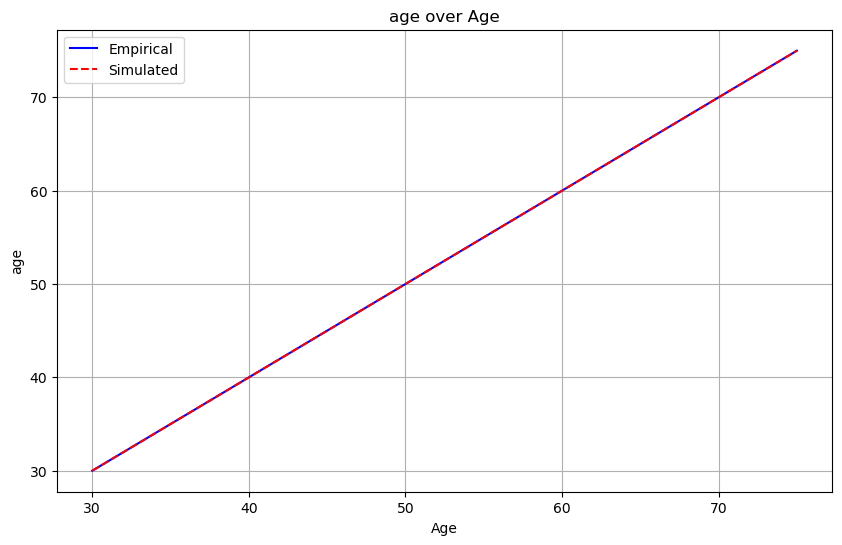

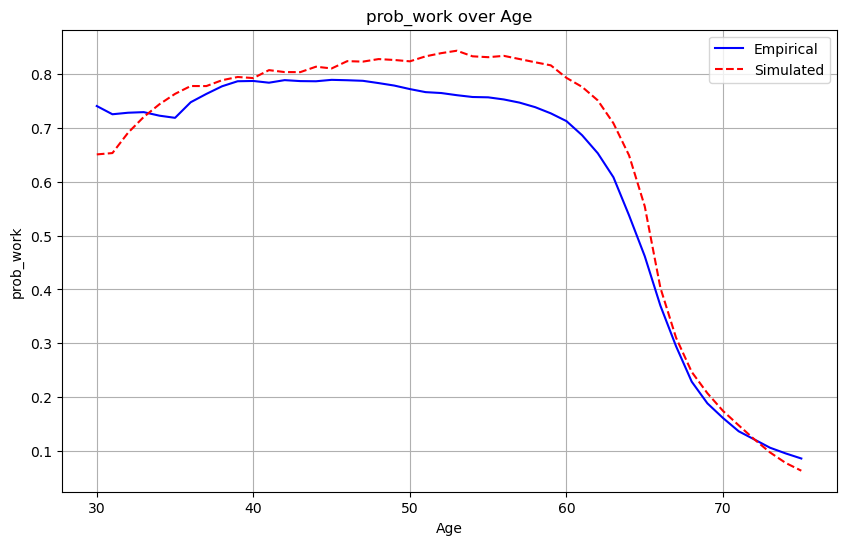

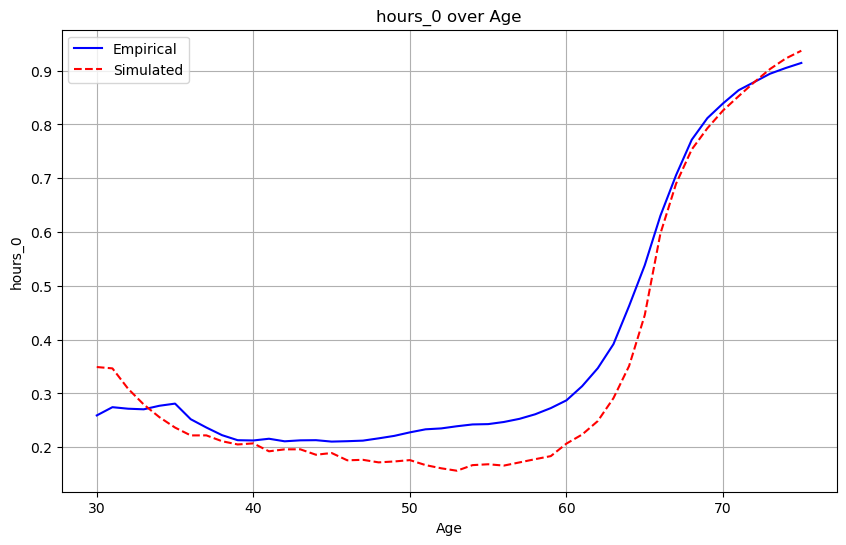

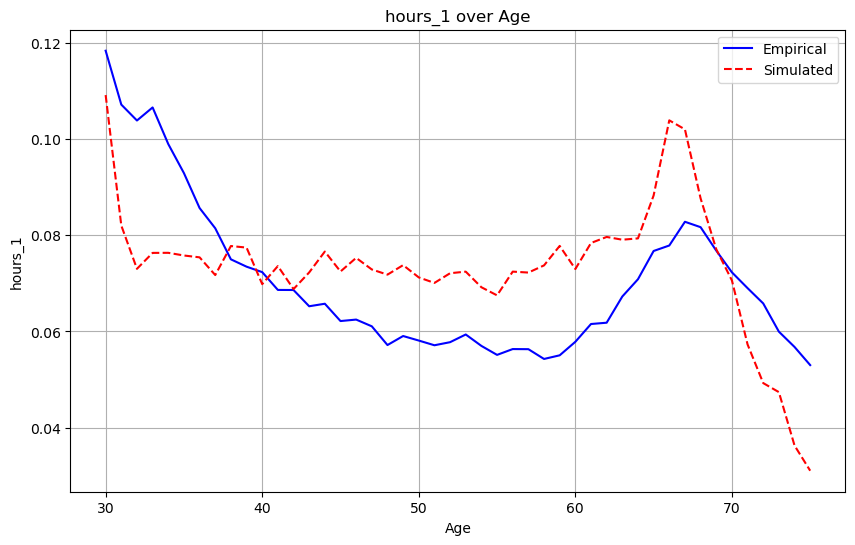

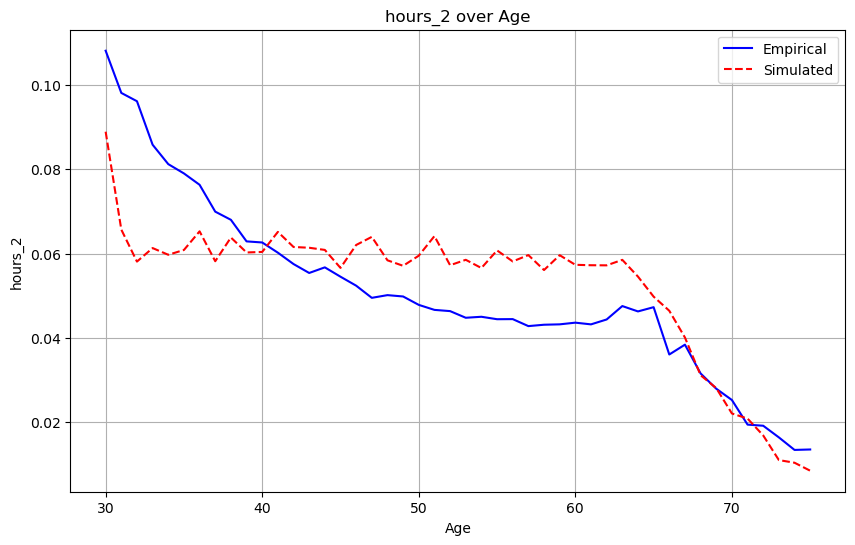

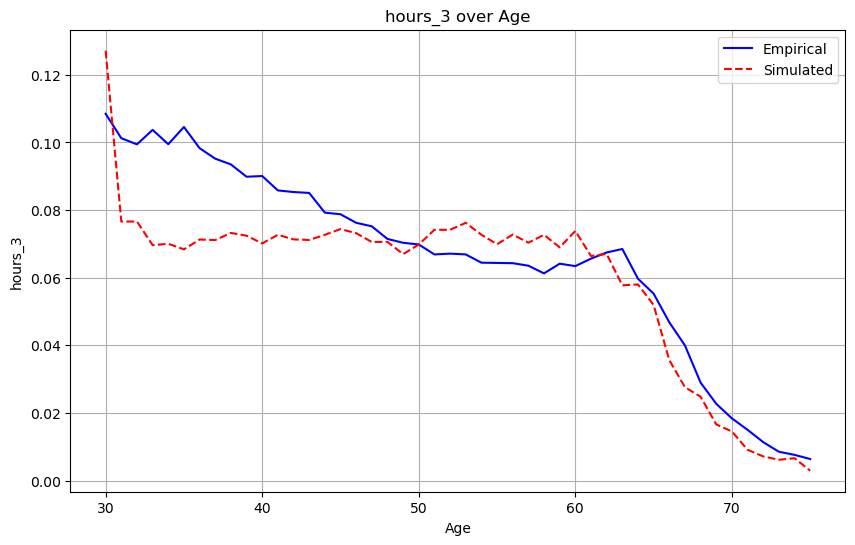

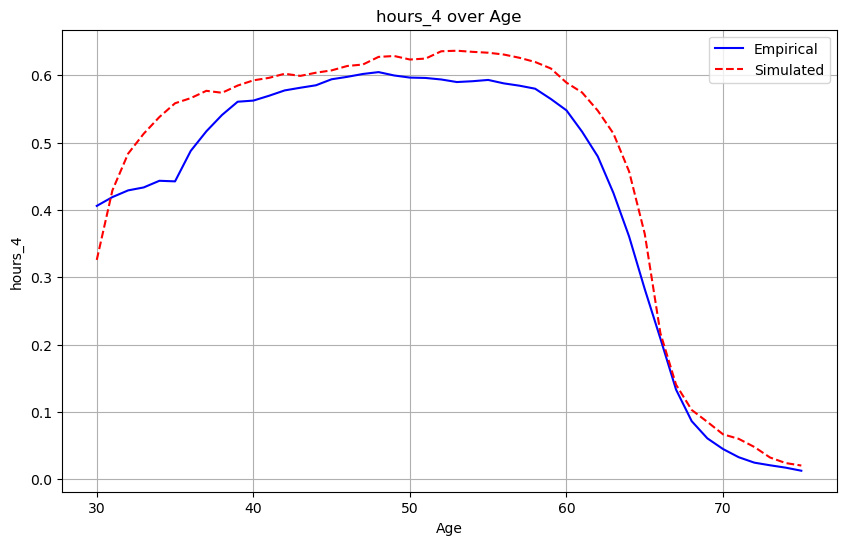

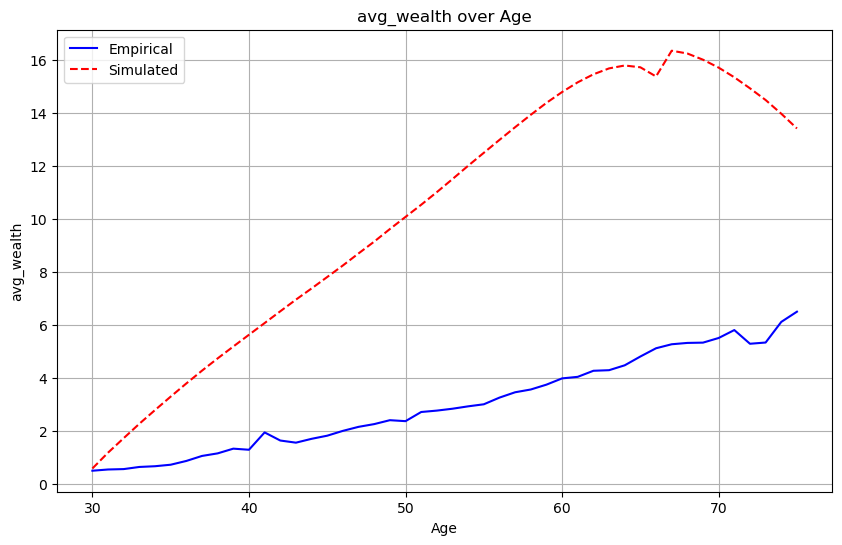

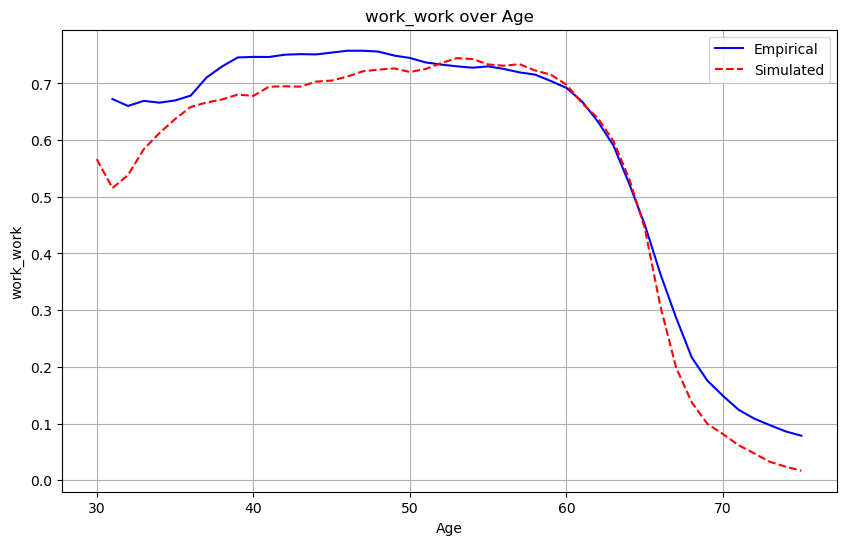

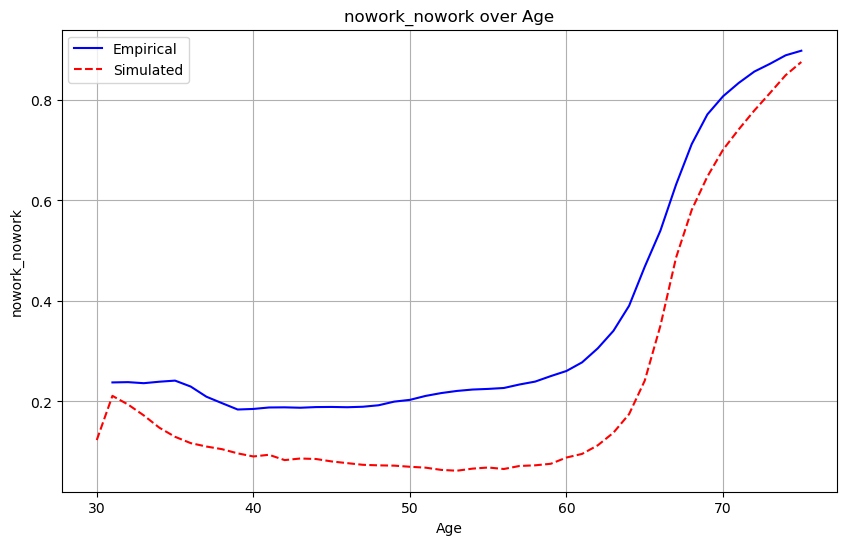

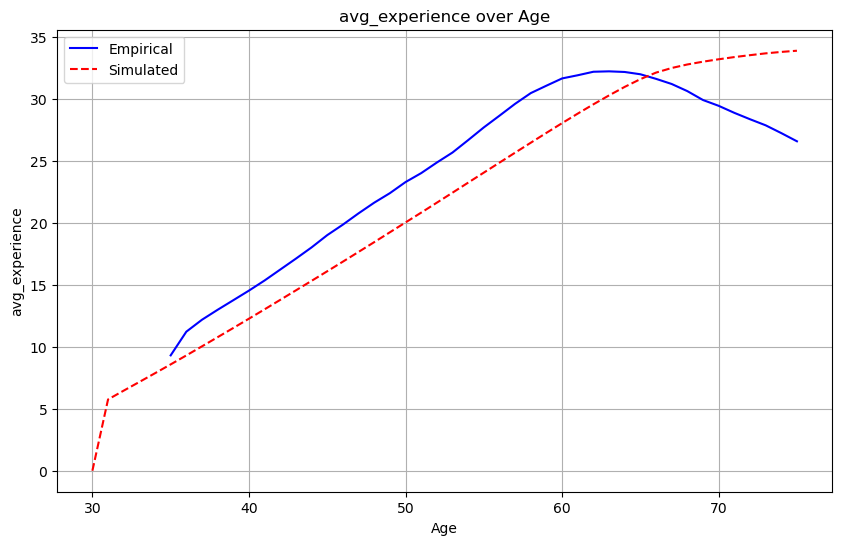

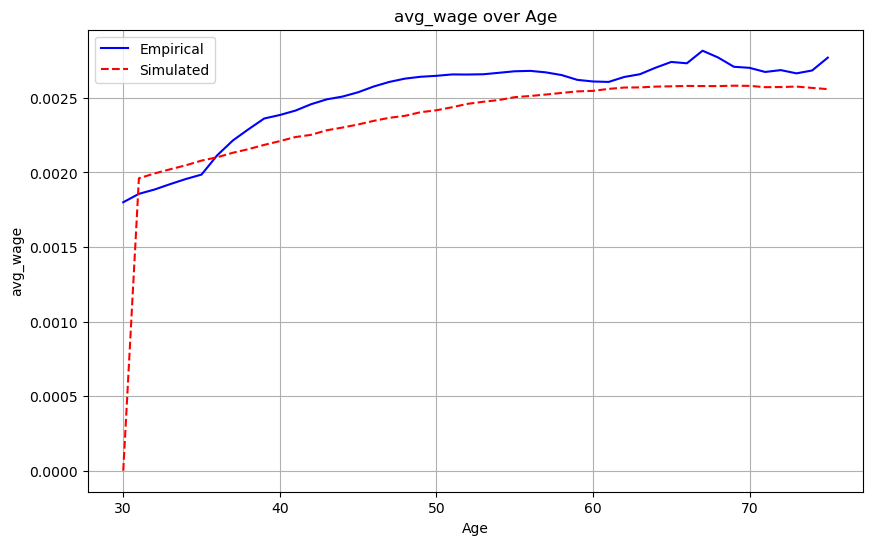

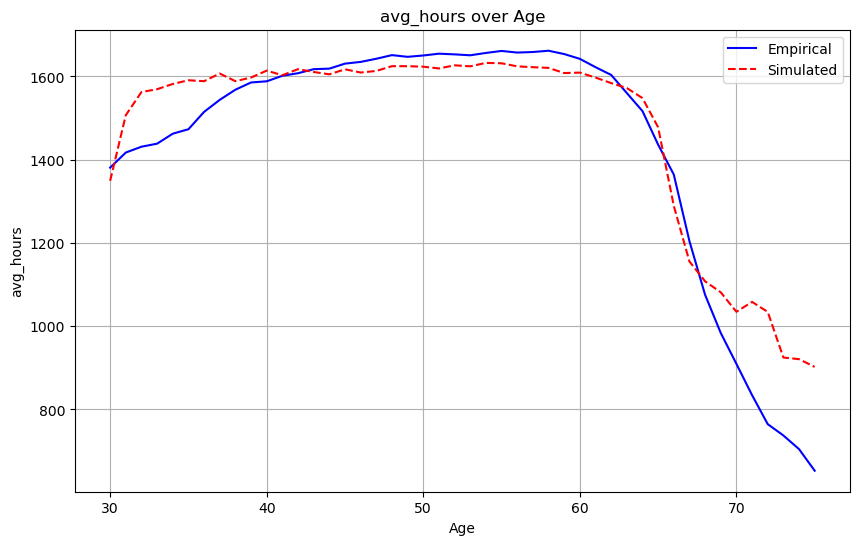

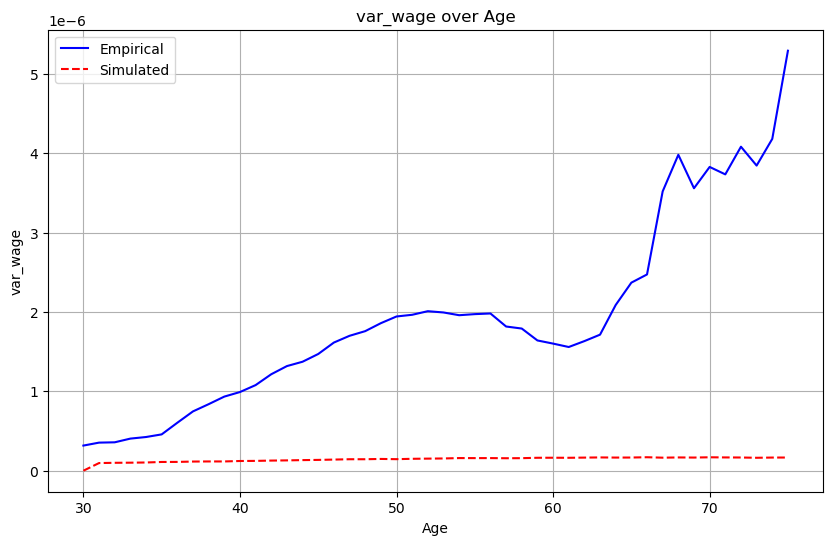

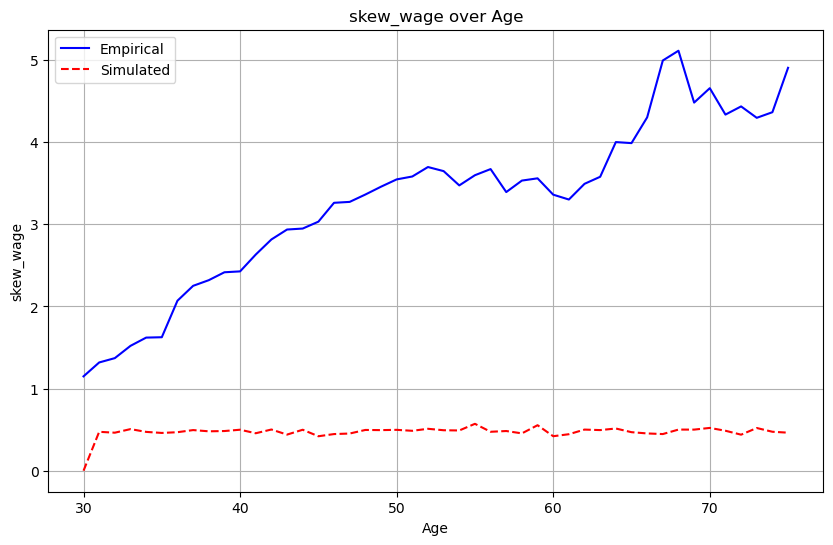

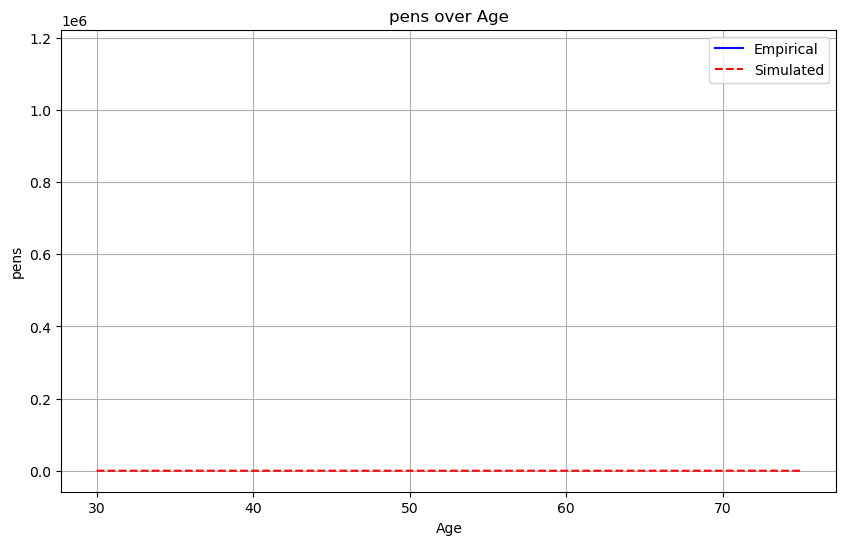

In [396]:
# plot the wealth over age for df_edu_1 and moments_sim in same plot

edu = df_edu_1

# run until age 75
edu = edu[edu["age"] <= 75]
moments_sim = moments_sim[moments_sim["age"] <= 75]
# plot the moments_sim and edu over age
for var in edu.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(edu["age"], edu[var], label=" ", color="blue")
    plt.plot(moments_sim["age"], moments_sim[var], label=" ", color="red", linestyle="--")
    plt.title(f"{var} over Age")
    plt.xlabel("Age")
    # give ylabel to clumn name
    plt.ylabel(var)
    #legend: red = simulated data, blue = empirical data
    plt.legend(["Empirical", "Simulated"])
    plt.grid()
    # save to file
    #save plots locally
    #plt.savefig(f"/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu3/{var}_over_age_edu3.png", dpi=100) 

plt.show()





In [ ]:
#save plots locally
plt.savefig("/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/simulated_vs_empirical.png")

In [ ]:
# 1) Define a grid of annual labor incomes from 0 to 100 000 DKK
income = np.linspace(0, 600_000, 500)

# 2) Calculate the supplement component:
#    income above the supplement threshold is taxed away at the supplement reduction rate
supp_threshold = options["model_params"]["supp_threshold"] * 100_000  # convert model units → DKK
supp_reduction_rate = options["model_params"]["supp_reduction_rate"]
income_over_supp = np.maximum(0.0, income - supp_threshold)
supplement = np.maximum(
    0.0,
    options["model_params"]["oap_max_supplement"] * 100_000  # max supplement in DKK
    - supp_reduction_rate * income_over_supp
)

# 3) Calculate the base pension component:
#    income above the OAP threshold reduces the base pension at the OAP reduction rate
oap_threshold = options["model_params"]["oap_threshold"] * 100_000
oap_reduction_rate = options["model_params"]["oap_reduction_rate"]
income_over_oap = np.maximum(0.0, income - oap_threshold)
base_pension = np.maximum(
    0.0,
    options["model_params"]["oap_base_amount"] * 100_000  # base amount in DKK
    - oap_reduction_rate * income_over_oap
)

# 4) Total annual pension is the sum of base pension and supplement
annual_pension = base_pension + supplement

# 5) Plot the piecewise-linear pension schedule
plt.figure(figsize=(8,5))
plt.plot(income, annual_pension, lw=2, label="Total Pension")
# mark the two thresholds
plt.axvline(supp_threshold, color="blue", linestyle="--", label="Supplement Threshold")
plt.axvline(oap_threshold, color="green", linestyle="--", label="Base Pension Threshold")
plt.xlabel("Annual Labor Income (DKK)")
plt.ylabel("Annual Old-Age Pension (DKK)")
plt.title("Old-Age Pension Schedule as a Function of Income")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()